In [2]:
import pandas
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
import os

In [3]:
PATH_TO_INPUT = '/mnt/research/IceCube/Gupta-Reco/22646/tfrecords/ftr/'
META_FILE_NAME = 'meta_ds_22646_from_0_to_1000_10_to_100TeV.ftr'
PULSES_FILE_NAME = 'pulses_ds_22646_from_0_to_1000_10_to_100TeV.ftr'

In [17]:
PATH_TO_INPUT = '/mnt/research/IceCube/Gupta-Reco/22645/tfrecords/ftr/'
META_FILE_NAME = 'meta_ds_22645_from_0_to_1000_10_to_100TeV.ftr'
PULSES_FILE_NAME = 'pulses_ds_22645_from_0_to_1000_10_to_100TeV.ftr'

In [ ]:
# PATH_TO_INPUT = '/mnt/scratch/baburish/TPN-training/highE_data'
# META_FILE_NAME = 'meta_ds_event_8_N100_from_0_to_10_1st_pulse.ftr'
# PULSES_FILE_NAME = 'pulses_ds_event_8_N100_from_0_to_10_1st_pulse.ftr'

In [2]:
# PATH_TO_INPUT = '/mnt/scratch/baburish/TPN-training/lowE_data'
# META_FILE_NAME = 'meta_ds_event_5352_from_0_to_10_1st_pulse.ftr'
# PULSES_FILE_NAME = 'pulses_ds_event_5352_from_0_to_10_1st_pulse.ftr'


In [18]:
events_meta_file = os.path.join(PATH_TO_INPUT, META_FILE_NAME)
events_pulses_file = os.path.join(PATH_TO_INPUT, PULSES_FILE_NAME)
geo_file = '/mnt/scratch/baburish/TPN-training/TriplePandelReco_JAX/data/icecube/detector_geometry.csv'

events_meta = pd.read_feather(events_meta_file)
events_data = pd.read_feather(events_pulses_file)
geo = pd.read_csv(geo_file)


int_cols_meta = ["event_id", "idx_start", "idx_end", "n_channel_HLC", "n_channel"]
events_meta[int_cols_meta] = events_meta[int_cols_meta].astype("Int64")

int_cols_data = ["event_id", "sensor_id", "is_HLC"]
events_data[int_cols_data] = events_data[int_cols_data].astype("Int64")

In [19]:
print(events_meta.head())

          event_id  idx_start  idx_end  n_channel_HLC  neutrino_energy  \
0  226450000000112          0       71             27     14080.679765   
1  226450000000148          0       26             13     12141.293095   
2  226450000002879          0      267             56    242924.656839   
3  226450000006369          0      212             64     20129.909201   
4  226450000007878          0       84             28     59049.327947   

     muon_energy  muon_energy_at_detector  muon_energy_lost       q_tot  \
0   11081.593539              5221.136212       1401.621063   77.750000   
1    8047.758997              1425.412978        703.025057   27.200000   
2  163396.468533              5937.374564      -9862.668558  304.350001   
3   12214.788643              1426.891810        196.560828  326.874999   
4   31777.103013              3903.630175       2730.885247   81.775000   

   n_channel  ...    muon_time   muon_pos_x   muon_pos_y   muon_pos_z  \
0         39  ...  1913.038048 

In [20]:
duplicates = events_data[events_data.duplicated()]
duplicate_counts = events_data.duplicated().sum()
print("Number of rows in events data:", len(events_data))
print("Number of duplicate rows in events data:", duplicate_counts)

duplicates = events_meta[events_meta.duplicated()]
duplicate_counts = events_meta.duplicated().sum()
print("Number of rows in events meta:", len(events_meta))
print("Number of duplicate rows in events meta:", duplicate_counts)

Number of rows in events data: 874806
Number of duplicate rows in events data: 0
Number of rows in events meta: 5621
Number of duplicate rows in events meta: 0


In [21]:
events_meta.iloc[0]['muon_energy_at_detector']/1000

5.221136212473537

In [22]:
def get_event_data(event_index: int) -> pd.DataFrame:
    ev_idx = event_index
    event_meta = events_meta.iloc[ev_idx]
    event_data = (events_data.iloc[int(event_meta.idx_start): int(event_meta.idx_end + 1)]).copy(deep=True)
    return event_meta, event_data

In [23]:
def get_event_data(event_index: int) -> pd.DataFrame:
    ev_idx = event_index
    event_meta = events_meta.iloc[ev_idx]
    print(event_meta)
    event_id = event_meta['event_id']
    
    event_data = events_data[events_data['event_id'] == event_id].copy()
    return event_meta, event_data

In [24]:
for ev_idx in range(2):
    event_meta = events_meta.iloc[ev_idx]
    event_id = event_meta['event_id']
    
    event_data = events_data[events_data['event_id'] == event_id].copy()
    
    print(f"Event ID: {event_id}")
    print("Number of pulses:", len(event_data))
    print(event_data.head())

Event ID: 226450000000112.0
Number of pulses: 72
          event_id  sensor_id     time  charge  is_HLC
0  226450000000112        319  14446.0   0.775       0
1  226450000000112        628  12667.0   1.175       0
2  226450000000112        684  13842.0   0.975       0
3  226450000000112        740  13684.0   0.875       1
4  226450000000112        742  13202.0   0.975       1
Event ID: 226450000000148.0
Number of pulses: 27
           event_id  sensor_id     time  charge  is_HLC
72  226450000000148       2315  11410.0   1.025       1
73  226450000000148       2315  11461.0   1.225       1
74  226450000000148       2316  11323.0   0.775       1
75  226450000000148       2316  11362.0   1.225       1
76  226450000000148       2316  11406.0   1.025       1


In [25]:
def get_per_dom_summary_from_sim_data(
    meta: pd.DataFrame,
    pulses: pd.DataFrame,
    charge_key='charge',
    correct_charge=False) -> pd.DataFrame:

    df_qtot = pulses[['sensor_id', charge_key]].groupby(by=['sensor_id'], as_index=False).sum()
    df_tmin = pulses[['sensor_id', 'time']].groupby(by=['sensor_id'], as_index=False).min()
    df = df_qtot.merge(geo.iloc[df_qtot['sensor_id']], on='sensor_id', how='outer')
    df['time'] = df_tmin['time'].values

    if correct_charge == True:
        df_corr = pulses[['sensor_id', 'charge_correction']].groupby(by=['sensor_id'], as_index=False).mean()
        df['charge'] = df['charge'].values * df_corr['charge_correction'].values

    if charge_key != 'charge':
        df.rename({charge_key: 'charge'}, inplace=True, axis='columns')
    return df

In [26]:
def replace_early_pulse(summary_data, pulses):
    corrected_time = np.zeros(len(summary_data))
    for i, row in summary_data.iterrows():
        s_id = row['sensor_id']
        q_tot = row['charge']
        t1 = row['time']

        idx = pulses['sensor_id'] == s_id
        pulses_this_dom = pulses[idx]
        corrected_time[i] = get_first_regular_pulse(pulses_this_dom, t1, q_tot)



    summary_data['time'] = corrected_time

In [27]:
def get_first_regular_pulse(pulses, t1, q_tot, crit_delta=10, crit_ratio = 5.e-3, crit_charge=100.):
    # technically, if we do remove early pulses, one could correct the total charge.
    # in practice, this would be an epsilon correction. Not worth adding the extra code complexity.
    # calculate ratio of charge within 10ns and 75ns of hit.
    if q_tot < crit_charge:
        return t1

    n = len(pulses)
    charge = pulses['charge'].to_numpy()
    time = pulses['time'].to_numpy()
    crit_delta_long = 75

    j = 0 # pts to end of crit_delta interval
    k = 0 # pts to end of crit_delta_long interval
    q_veto = 0
    q_long = 0
    for i in range(0, n):
        crit_time = time[i] + crit_delta
        if j < i:
            j = i

        # extend window
        while j < n and time[j] < crit_time:
            q_veto += charge[j]
            j += 1

        crit_time = time[i] + crit_delta_long
        if k < i:
            k = i

        # extend window
        while k < n and time[k] < crit_time:
            q_long += charge[k]
            k += 1

        r_veto = q_veto / q_long
        if r_veto > crit_ratio:
            # found a reasonable pulse
            # break
            break

        # remove early pulse
        q_long -= charge[i]
        q_veto -= charge[i]

    return time[i]

In [28]:
high_idx=events_meta['muon_energy'].argmax()

In [29]:
high_idx

5024

In [30]:
index = 0
meta, pulses = get_event_data(index)
event_data = get_per_dom_summary_from_sim_data(meta, pulses)
replace_early_pulse(event_data, pulses)

event_id                   226450000000112.0
idx_start                                0.0
idx_end                                 71.0
n_channel_HLC                           27.0
neutrino_energy                 14080.679765
muon_energy                     11081.593539
muon_energy_at_detector          5221.136212
muon_energy_lost                 1401.621063
q_tot                                  77.75
n_channel                               39.0
muon_zenith                         1.741547
muon_azimuth                         2.12238
muon_time                        1913.038048
muon_pos_x                       -1339.33649
muon_pos_y                       2465.244145
muon_pos_z                       -460.888321
spline_mpe_zenith                   1.731796
spline_mpe_azimuth                  2.115065
spline_mpe_time                 11499.741927
spline_mpe_pos_x                  142.072745
spline_mpe_pos_y                   48.951673
spline_mpe_pos_z                    27.51545
Name: 0, d

In [16]:
# for illustration, we look at the summary data of the brightest DOM.
ix = event_data['charge'].argmax()
print(event_data.loc[ix, ['sensor_id', 'charge', 'x', 'y', 'z', 'time']])

# and remember the ID of the brightest sensor.
brightest_sensor_id = event_data.loc[ix, 'sensor_id']
print("")

# just FYI, in case you want to know the string and dom:
string, om = divmod(brightest_sensor_id, 60)
string += 1 # string indexing starts at 1 IceCube
om += 1 # om indexing starts at 1 in IceCube
print(f"selected DOM is located on IceCube string {string} and is number {om}.")

sensor_id     656.0
charge         35.3
x            158.94
y           -345.23
z           -453.33
time         9883.0
Name: 21, dtype: Float64

selected DOM is located on IceCube string 11 and is number 57.


In [17]:
# let's get all pulses for this DOM (and not just the 1st one)
sensor_selection = pulses['sensor_id'] == brightest_sensor_id
pulses_this_dom = pulses[sensor_selection]

print(f"selected DOM has recorded {len(pulses_this_dom)} pulses.")

selected DOM has recorded 34 pulses.


In [18]:
def plot_event(df, index, geo=None, outfile=None, plot_pdf=None):
    fig = plt.figure(figsize=(12,8))
    ax = plt.subplot(projection='3d')
    ax.set_xlabel('pos.x [m]', fontsize=16, labelpad=-25)
    ax.set_ylabel('pos.y [m]', fontsize=16, labelpad=-25)
    ax.set_zlabel('pos.z [m]', fontsize=16, labelpad=-25)

    try:
        im = ax.scatter(geo['x'], geo['y'], geo['z'], s=0.9, c='0.7', alpha=0.8)
    except:
        pass

    im = ax.scatter(df['x'], df['y'], df['z'], s=np.sqrt(df['charge']*100), c=df['time'],
                    cmap='rainbow_r',  edgecolors='k', zorder=1000)
    ax.tick_params(axis='both', which='both', width=1.5, colors='0.0', labelsize=16)
    cb = plt.colorbar(im, orientation="vertical", pad=0.1)
    cb.set_label(label='time [ns]', size='x-large')
    cb.ax.tick_params(labelsize='x-large')
    plt.title(f'Event {index}')
    if plot_pdf:
        pdf.savefig()
        plt.close()
    else:
        plt.show()
    # if outfile is None:
    #     plt.show()

    # else:
    #     plt.savefig(outfile, dpi=300)

event_id                           0.0
idx_start                          0.0
idx_end                          102.0
n_channel_HLC                     58.0
neutrino_energy            2451.110391
muon_energy                1990.255064
muon_energy_at_detector           <NA>
muon_energy_lost                  <NA>
q_tot                           74.975
n_channel                         76.0
muon_zenith                   1.887855
muon_azimuth                  5.383567
muon_time                  9597.763386
muon_pos_x                  227.740994
muon_pos_y                 -332.002079
muon_pos_z                 -487.986316
spline_mpe_zenith             1.941071
spline_mpe_azimuth            5.385458
spline_mpe_time            10764.79648
spline_mpe_pos_x              17.84622
spline_mpe_pos_y            -75.731756
spline_mpe_pos_z           -382.186833
Name: 0, dtype: Float64
selected DOM is located on IceCube string 11 and is number 57.


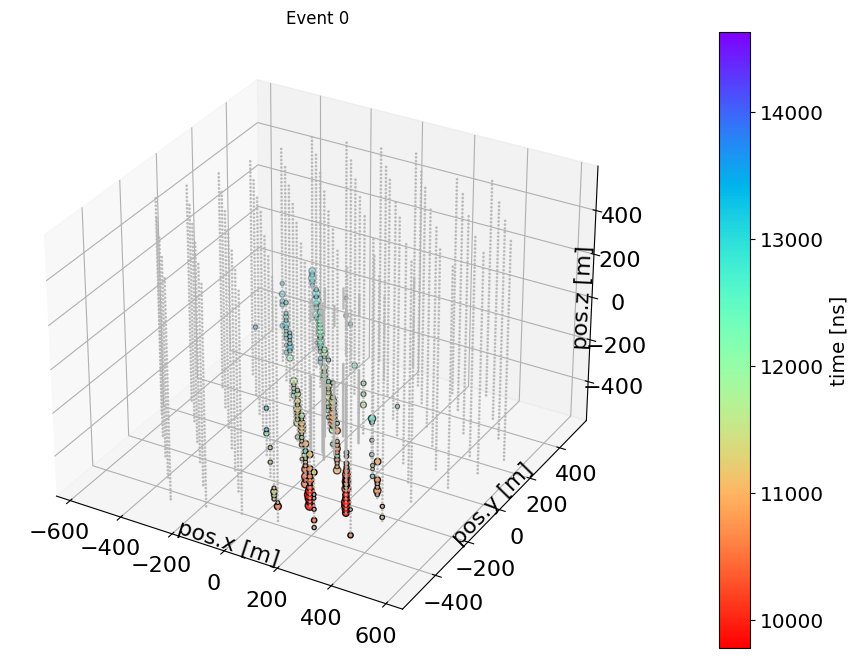

In [19]:
index = high_idx
meta, pulses = get_event_data(index)
event_data = get_per_dom_summary_from_sim_data(meta, pulses)
replace_early_pulse(event_data, pulses)
ix = event_data['charge'].argmax()

# and remember the ID of the brightest sensor.
brightest_sensor_id = event_data.loc[ix, 'sensor_id']

# just FYI, in case you want to know the string and dom:
string, om = divmod(brightest_sensor_id, 60)
string += 1 # string indexing starts at 1 IceCube
om += 1 # om indexing starts at 1 in IceCube
print(f"selected DOM is located on IceCube string {string} and is number {om}.")
plot_event(event_data, index, geo=geo)

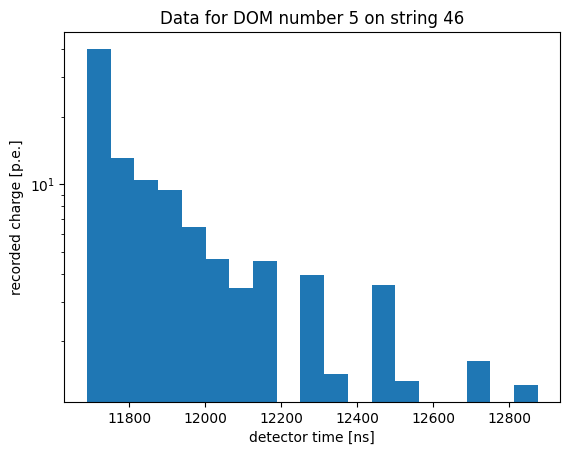

In [72]:
# let's visualize pulses
min_time = pulses_this_dom['time'].min()
max_time = pulses_this_dom['time'].max()
time_bins = np.linspace(min_time, max_time, 20)

plt.figure()
plt.hist(pulses_this_dom['time'], bins=time_bins, weights=pulses_this_dom['charge'])
plt.yscale('log')
plt.ylabel("recorded charge [p.e.]")
plt.xlabel("detector time [ns]")
plt.title(f"Data for DOM number {om} on string {string}")
plt.show()

In [31]:
with PdfPages("output.pdf") as pdf:
    for i in range(20, 30):
        index = i
        meta, pulses = get_event_data(index)
        event_data = get_per_dom_summary_from_sim_data(meta, pulses)
        replace_early_pulse(event_data, pulses)
        ix = event_data['charge'].argmax()

        # and remember the ID of the brightest sensor.
        brightest_sensor_id = event_data.loc[ix, 'sensor_id']
        print("")

        # just FYI, in case you want to know the string and dom:
        string, om = divmod(brightest_sensor_id, 60)
        string += 1 # string indexing starts at 1 IceCube
        om += 1 # om indexing starts at 1 in IceCube
        print(f"selected DOM is located on IceCube string {string} and is number {om}.")
        plot_event(event_data, geo=geo, plot_pdf=True)
        d = pdf.infodict()
        d['Title'] = 'My analysis plots'
        d['Author'] = 'Rishi Babu'
        d['Subject'] = 'Pulse/meta data visualization'
        d['Keywords'] = 'IceCube, muons, matplotlib'


selected DOM is located on IceCube string 56 and is number 56.

selected DOM is located on IceCube string 39 and is number 49.

selected DOM is located on IceCube string 59 and is number 47.

selected DOM is located on IceCube string 44 and is number 59.

selected DOM is located on IceCube string 56 and is number 28.

selected DOM is located on IceCube string 76 and is number 19.

selected DOM is located on IceCube string 28 and is number 7.

selected DOM is located on IceCube string 57 and is number 20.

selected DOM is located on IceCube string 67 and is number 58.

selected DOM is located on IceCube string 55 and is number 4.


In [34]:
pulses_this_dom

,event_id,sensor_id,time,charge,is_HLC
774257,226450088406994,2897,11226.0,1.725,1
774258,226450088406994,2897,11241.0,2.225,1
774259,226450088406994,2897,11267.0,1.125,1


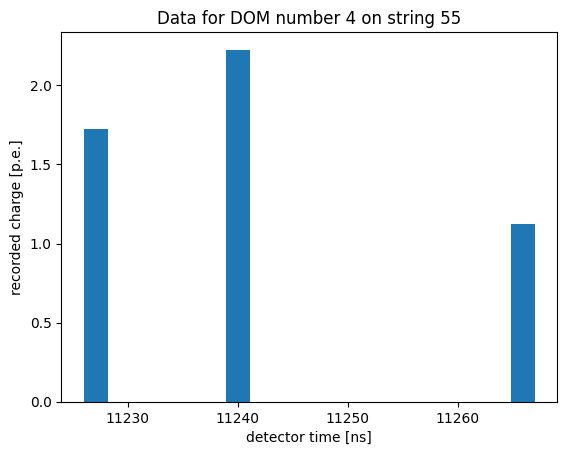

In [32]:
# let's visualize pulses
min_time = pulses_this_dom['time'].min()
max_time = pulses_this_dom['time'].max()
time_bins = np.linspace(min_time, max_time, 20)

plt.figure()
plt.hist(pulses_this_dom['time'], bins=time_bins, weights=pulses_this_dom['charge'])
# plt.yscale('log')
plt.ylabel("recorded charge [p.e.]")
plt.xlabel("detector time [ns]")
plt.title(f"Data for DOM number {om} on string {string}")
plt.show()

In [130]:
counts, bin_edges = np.histogram(pulses_this_dom['time'], bins=time_bins, density=False)

# Convert counts to PDF (sum to 1)
pdf = counts / counts.sum()

# Bin centers for plotting
bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2

print("Bin centers:", bin_centers)
print("PDF:", pdf)

Bin centers: [13117.42105263 13124.26315789 13131.10526316 13137.94736842
 13144.78947368 13151.63157895 13158.47368421 13165.31578947
 13172.15789474 13179.         13185.84210526 13192.68421053
 13199.52631579 13206.36842105 13213.21052632 13220.05263158
 13226.89473684 13233.73684211 13240.57894737]
PDF: [0.1 0.2 0.  0.1 0.  0.  0.1 0.  0.1 0.  0.  0.1 0.  0.1 0.1 0.  0.  0.
 0.1]


x grid: [13114.         13115.31313131 13116.62626263 13117.93939394
 13119.25252525 13120.56565657 13121.87878788 13123.19191919
 13124.50505051 13125.81818182 13127.13131313 13128.44444444
 13129.75757576 13131.07070707 13132.38383838 13133.6969697
 13135.01010101 13136.32323232 13137.63636364 13138.94949495
 13140.26262626 13141.57575758 13142.88888889 13144.2020202
 13145.51515152 13146.82828283 13148.14141414 13149.45454545
 13150.76767677 13152.08080808 13153.39393939 13154.70707071
 13156.02020202 13157.33333333 13158.64646465 13159.95959596
 13161.27272727 13162.58585859 13163.8989899  13165.21212121
 13166.52525253 13167.83838384 13169.15151515 13170.46464646
 13171.77777778 13173.09090909 13174.4040404  13175.71717172
 13177.03030303 13178.34343434 13179.65656566 13180.96969697
 13182.28282828 13183.5959596  13184.90909091 13186.22222222
 13187.53535354 13188.84848485 13190.16161616 13191.47474747
 13192.78787879 13194.1010101  13195.41414141 13196.72727273
 13198.04040404 13

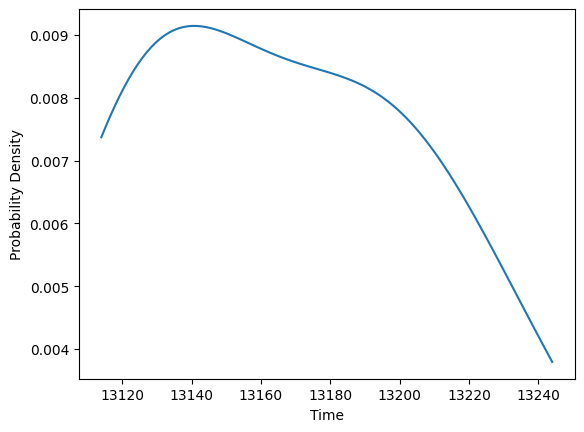

In [131]:
from scipy.stats import gaussian_kde

# Kernel Density Estimate
time_array=pulses_this_dom['time']
kde = gaussian_kde(time_array)

# Evaluate PDF on a grid
x_grid = np.linspace(time_array.min(), time_array.max(), 100)
pdf_values = kde(x_grid)

# Normalize to make sure integral = 1
pdf_values /= np.trapz(pdf_values, x_grid)

print("x grid:", x_grid)
print("PDF values:", pdf_values)
import matplotlib.pyplot as plt

plt.plot(x_grid, pdf_values)
plt.xlabel("Time")
plt.ylabel("Probability Density")
plt.show()